# Predictive Quality Control for Manufacturing

## Importing Required Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import gaussian_kde
import os

## Data Preprocessing

In [2]:
def preprocess_data(file_path):
    # Load dataset
    data = pd.read_csv(file_path)

    # Check for non-numeric columns and attempt encoding
    for column in data.select_dtypes(include=['object']).columns:
        # If the column is categorical, encode it
        if data[column].dtype == 'object':
            # Option 1: Label encoding (if there are few unique values)
            label_encoder = LabelEncoder()
            data[column] = label_encoder.fit_transform(data[column])
    
    # Separate features (X) and target (y)
    X = data.drop(columns=['y1', 'y2', 'y3'])  # Assuming 'y1' and 'y2' are the target columns
    y = data[['y1', 'y2', 'y3']]  # Adjust this as needed
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize the input data (features)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, data

## Exploratory Data Analysis (EDA)

In [3]:
def perform_eda(data):
    plt.figure(figsize=(12, 8))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Heatmap')
    plt.show()

    for col in ['u1', 'u2', 'u3']:
        try: 
            sns.scatterplot(x=data[col], y=data['y1'])
            plt.title(f'{col} vs dry matter')
            plt.xlabel(col)
            plt.ylabel('dry matter')
            plt.show()

            sns.scatterplot(x=data[col], y=data['y2'])
            plt.title(f'{col} vs flow')
            plt.xlabel(col)
            plt.ylabel('flow')
            plt.show()

            sns.scatterplot(x=data[col], y=data['y3'])
            plt.title(f'{col} vs temperature')
            plt.xlabel(col)
            plt.ylabel('temperature')
            plt.show()
        except:
            pass

## Predictive Modeling

In [4]:
def train_model(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    joblib.dump(model, 'tension_prediction_model.pkl')
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
    return mse, r2, y_pred

## Quality Control Integration

In [5]:
def plot_spc_chart(y_test, threshold, title):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values, label='Actual dry matter', marker='o')
    plt.axhline(y_test.mean(), color='r', linestyle='dashed', label='Mean dry matter')
    plt.axhline(threshold, color='b', linestyle='solid', label='Upper Control Line')
    plt.axhline(-threshold, color='b', linestyle='solid', label='Lower Control Line')


    plt.xlabel('Sample Index')
    plt.ylabel('dry matter')
    plt.legend()
    plt.title('Statistical Process Control Chart for ' + title)
    plt.show()

# Alarms

In [6]:
def trigger_alarm(y_pred, threshold=1.5):
    alarms = y_pred > threshold
    if np.any(alarms):
        print("Alarm triggered! Predicted values exceed the threshold.")
    else:
        print("No alarm. All predicted values are within the threshold.")

## Six Sigma Framework

In [7]:
def calculate_dpmk(y_actual, y_predicted, threshold=0.05):
    # Calculating Defects Per Million Opportunities (DPMO)
    defects_y1 = np.sum(np.abs(y_actual[:, 0] - y_predicted[:, 0]) > threshold)
    defects_y2 = np.sum(np.abs(y_actual[:, 1] - y_predicted[:, 1]) > threshold)
    defects_y3 = np.sum(np.abs(y_actual[:, 2] - y_predicted[:, 2]) > threshold)
    
    opportunities = len(y_actual) * 3  # y1, y2 and y3
    defects =  defects_y1 + defects_y2 + defects_y3
    
    return (defects / opportunities) * 1_000_000

def calculate_cpk(data, usl, lsl):
    # Calculating Process Capability Index (Cpk)
    mean = data.mean()
    std_dev = data.std()
    cpu = (usl - mean) / (3 * std_dev)
    cpl = (mean - lsl) / (3 * std_dev)
    
    return min(cpu, cpl)

In [8]:
def findOutliers(dataframe, threshold, key) -> pd.DataFrame:
    if key not in dataframe.columns:
        raise ValueError("The DataFrame does not contain a 'y1' column.")

    outliers = dataframe[(dataframe[key] > threshold)] #| (dataframe[key] < -1*threshold) Only positive for testing
    
    return outliers

In [9]:
def plot_distribution(data, column, title):
    plt.figure(figsize=(12, 6))
    
    # Plot histogram with more bins
    sns.histplot(data[column], kde=False, bins=50, color='blue', label=f'{column} Histogram')
    
    plt.title(f'Distribution of {title}')
    plt.xlabel(f'{column}')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [10]:
def plot_kde_manual(data, column):
    x_values = np.linspace(data[column].min(), data[column].max(), 100)
    kde = gaussian_kde(data[column])  # Compute KDE
    y_values = kde(x_values)

    plt.figure(figsize=(8, 4))
    plt.hist(data[column], bins=30, density=True, alpha=0.5, color='blue', edgecolor='black', label='Histogram')
    plt.plot(x_values, y_values, color='red', label='KDE')
    
    # Axis Labels
    plt.xlabel("Value")  
    plt.ylabel("Density")
    plt.title(f'KDE of {column}')
    plt.legend()
    plt.show()

## Running the Workflow

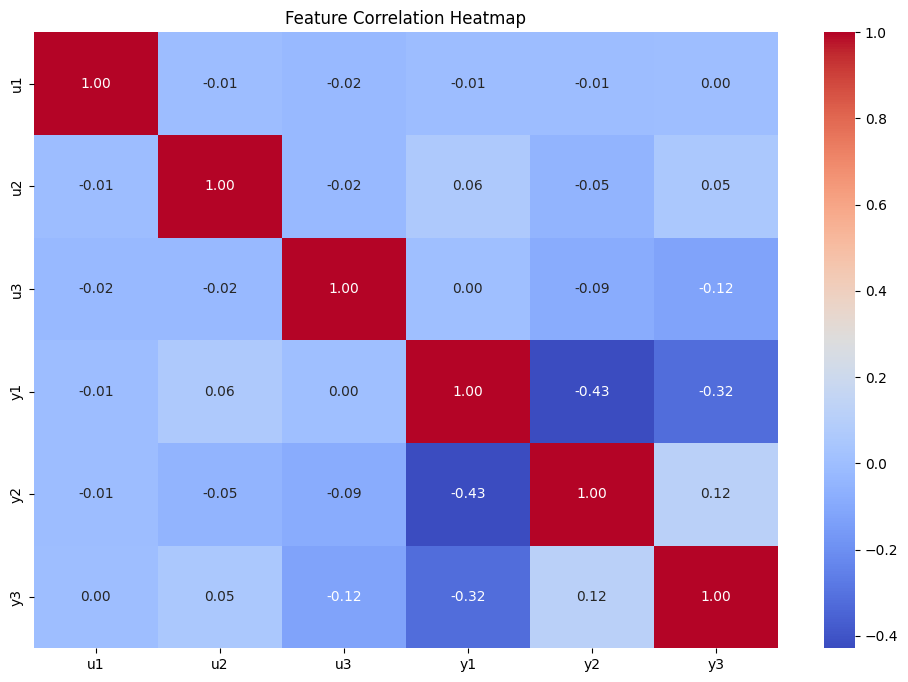

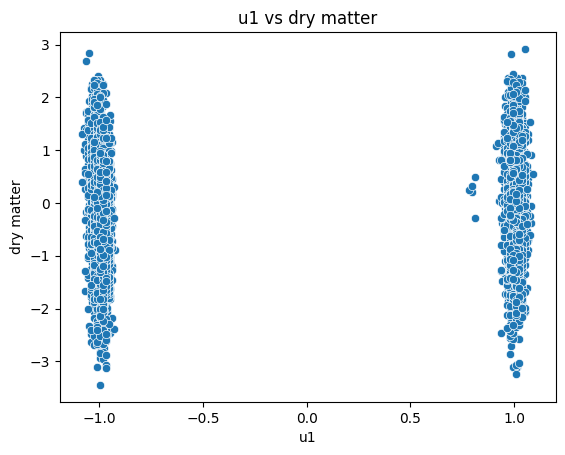

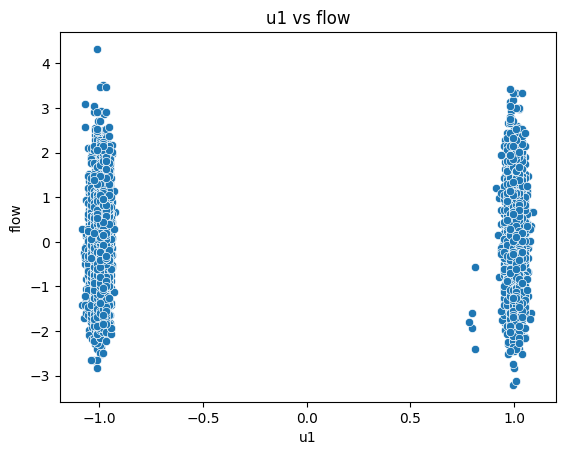

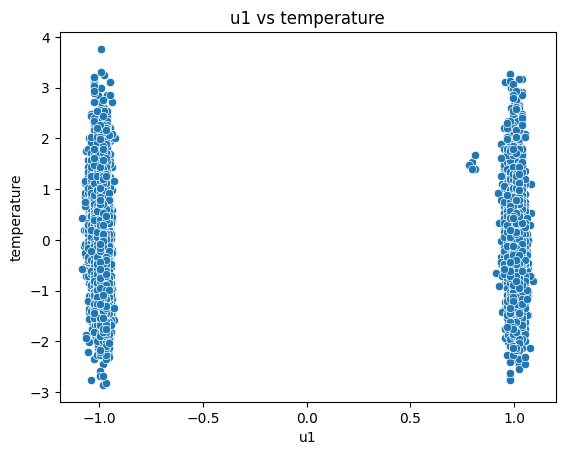

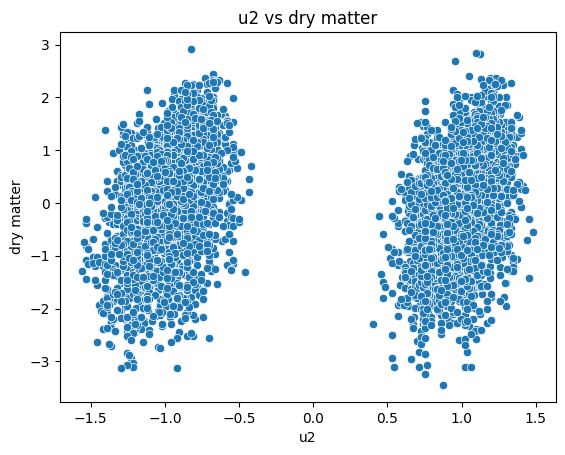

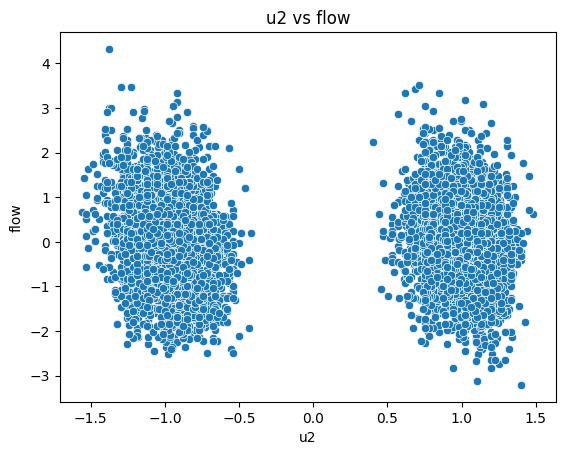

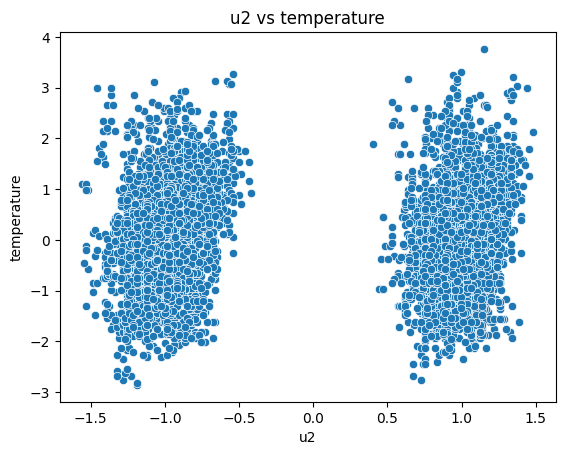

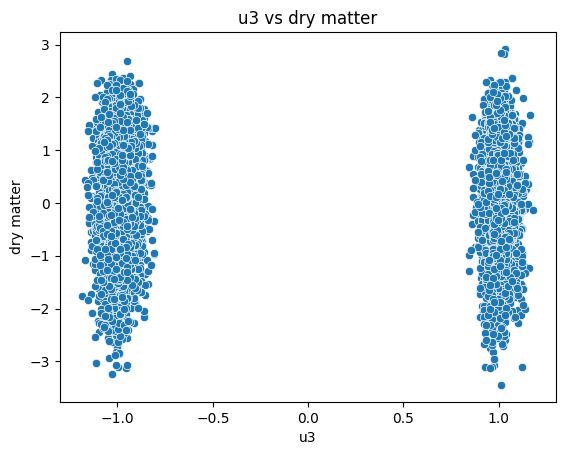

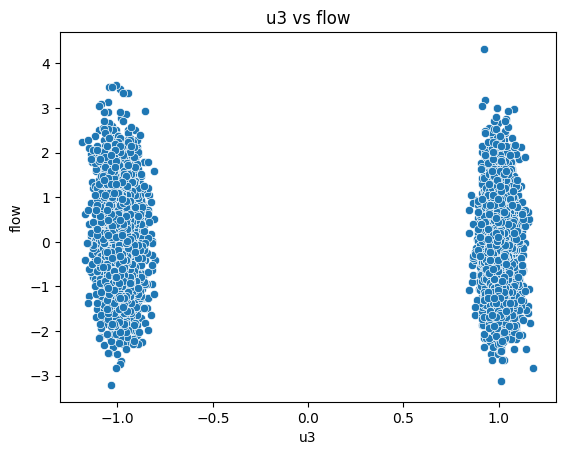

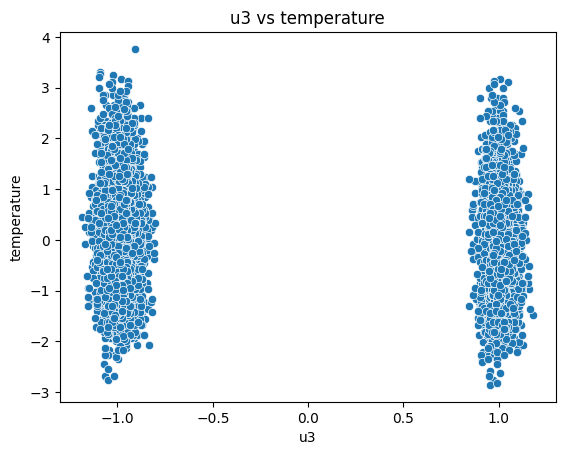

Model Performance: MSE = 0.9951, R² Score = 0.0094
Threshold = 1.4717438537150243
Threshold = 1.507057674955617
Threshold = 1.5436197316479248


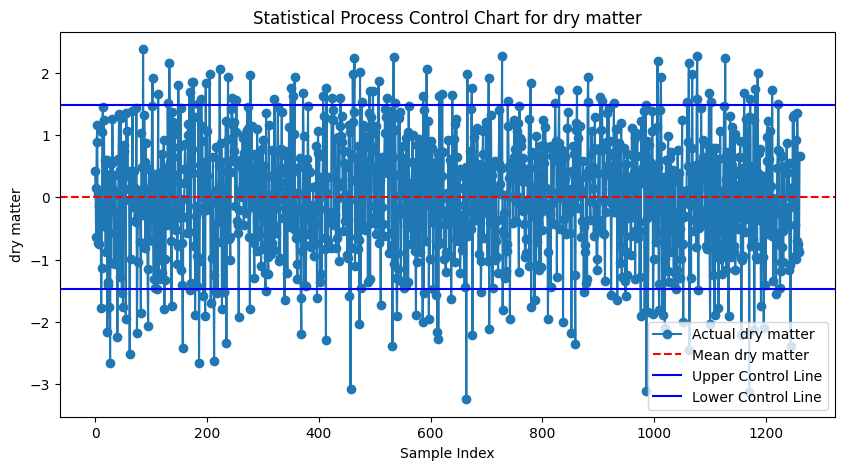

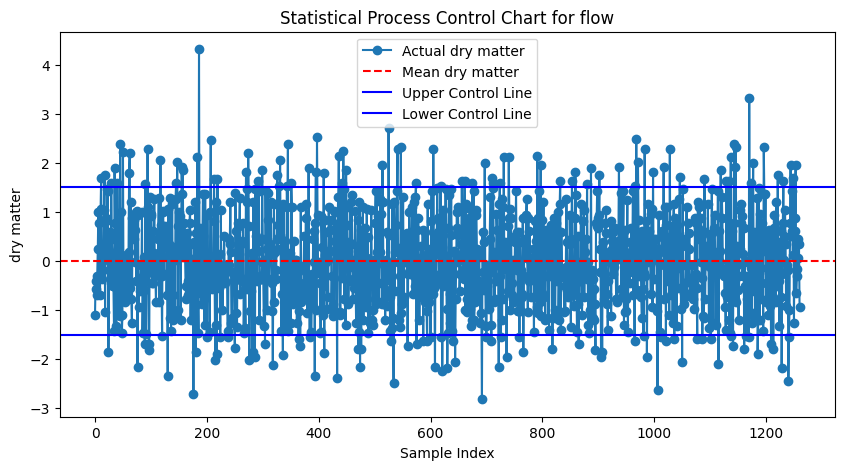

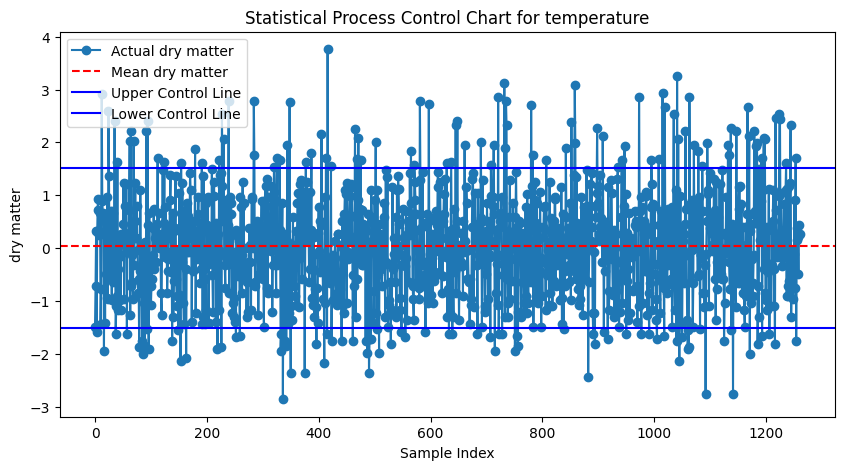

No alarm. All predicted values are within the threshold.


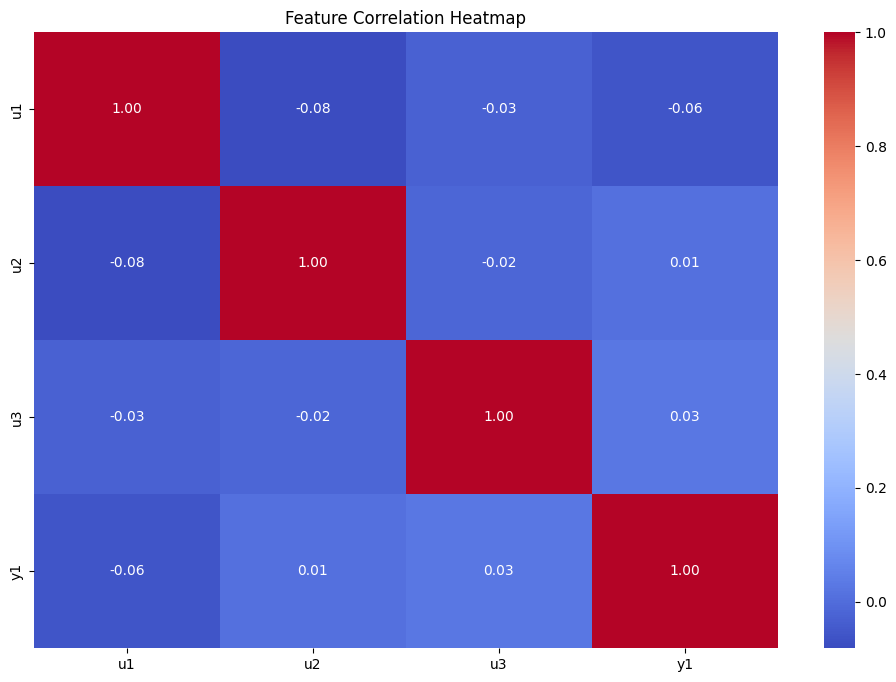

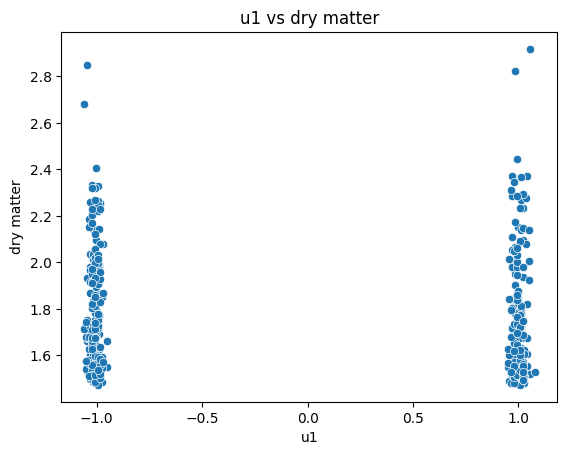

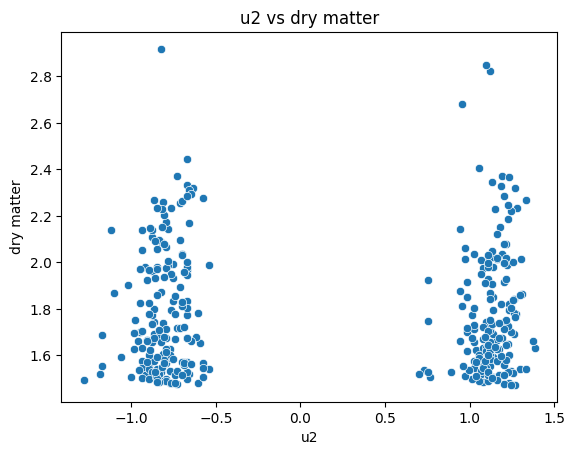

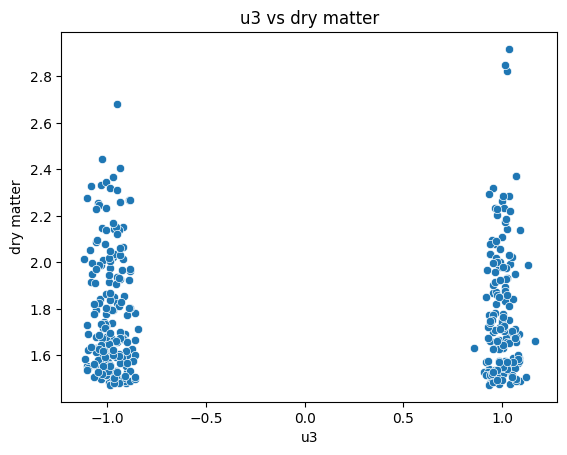

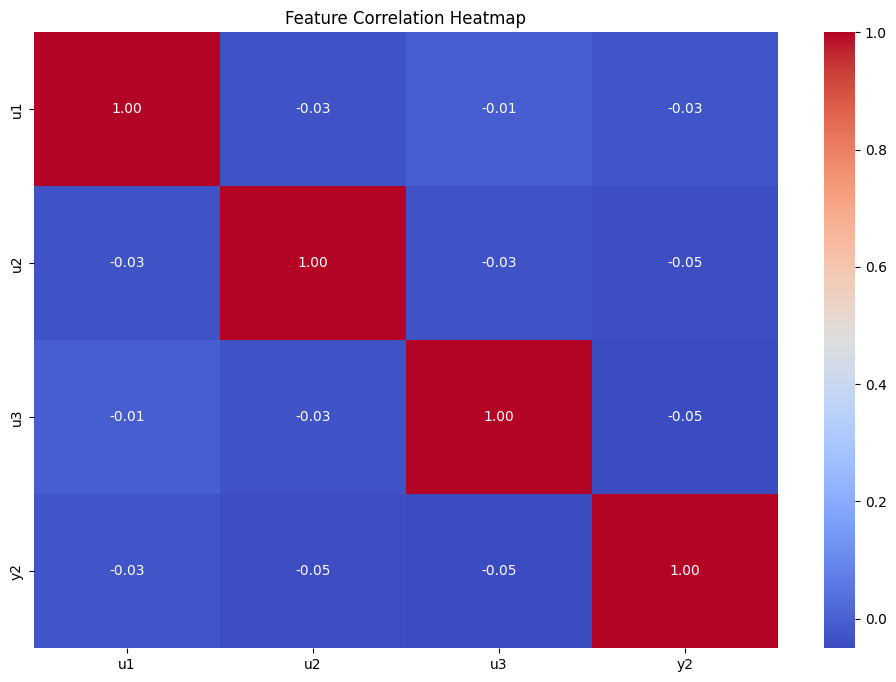

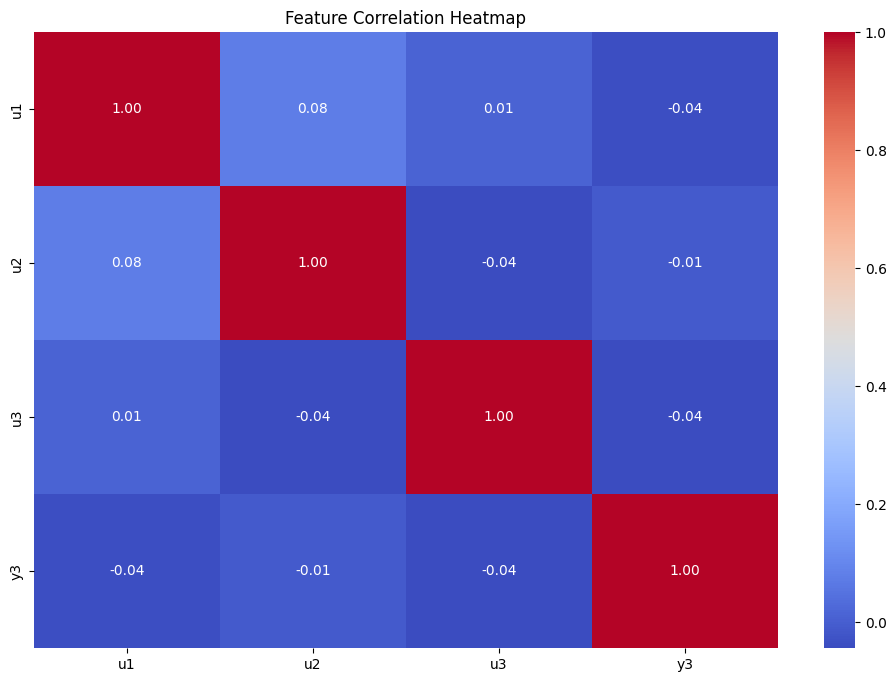

Defects Per Million Opportunities (DPMO): 962992.33
Process Capability Index (Cpk): 0.00


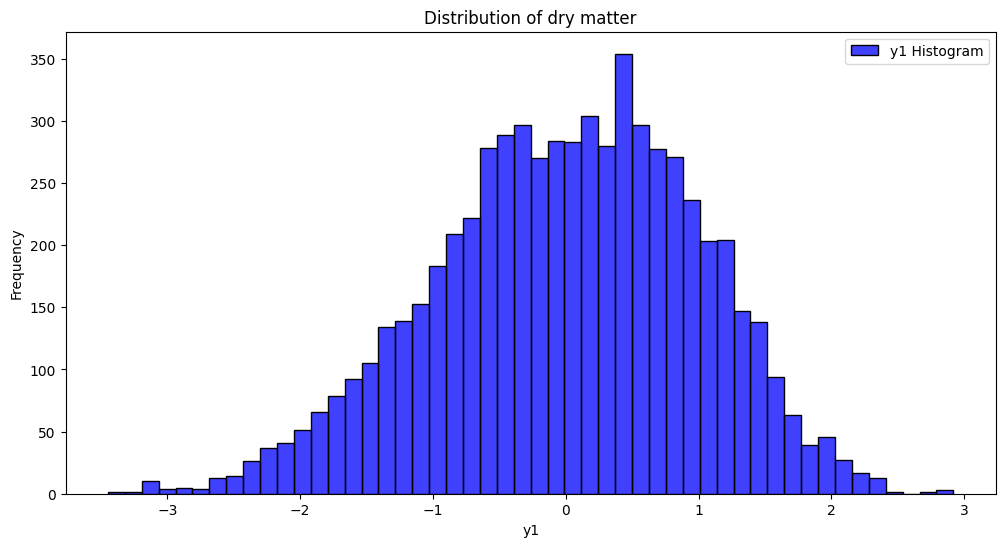

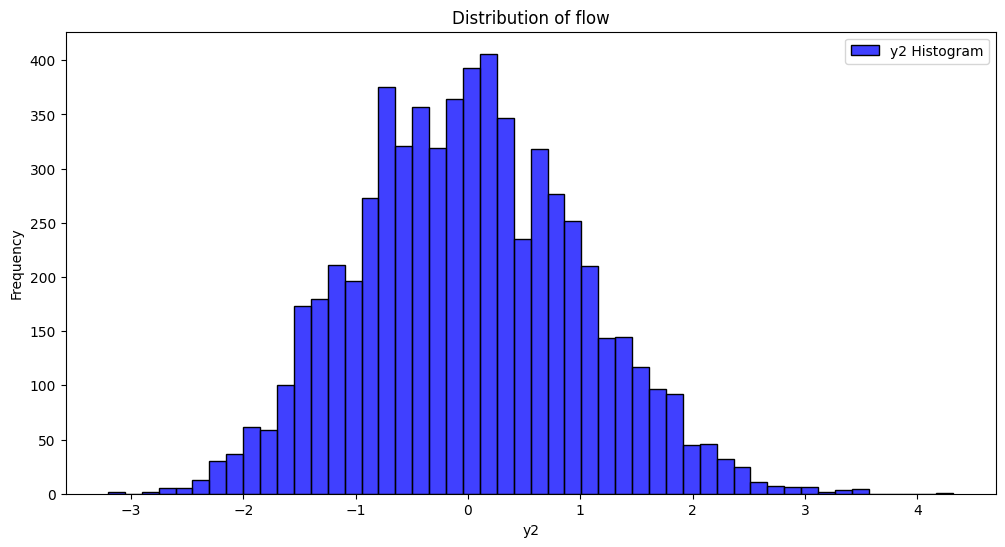

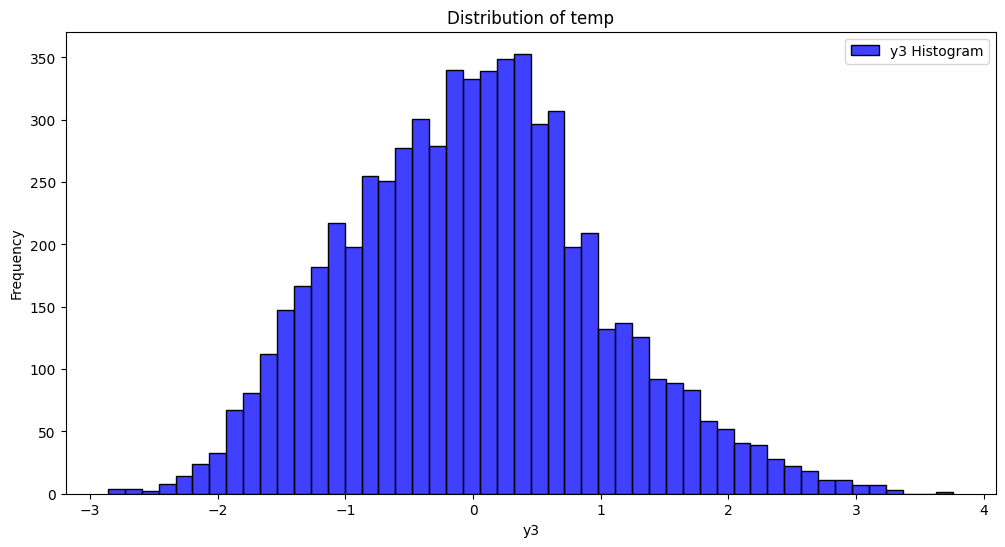

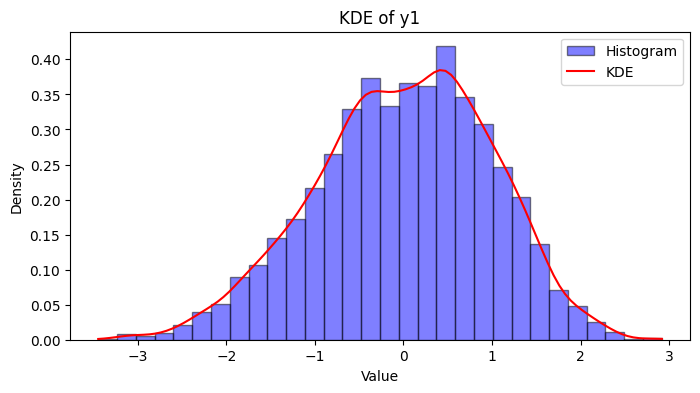

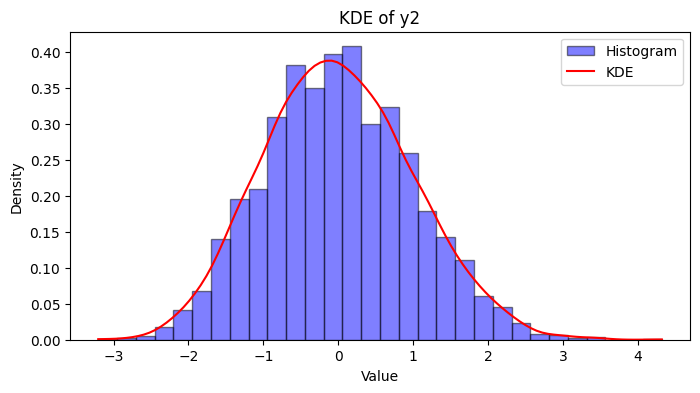

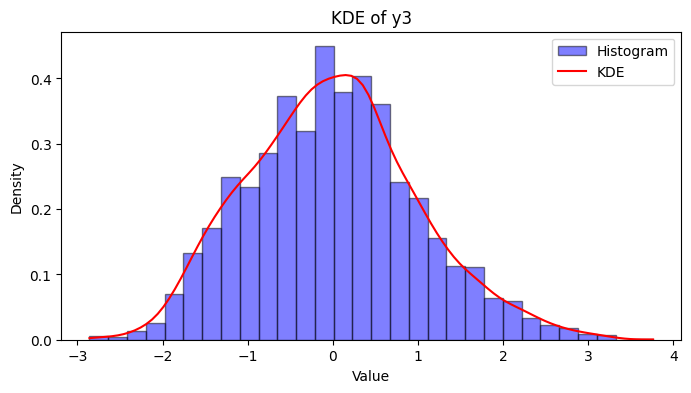

In [ ]:
# Load and preprocess the dataset
file_path = 'processData2.csv'  # Update this with the actual dataset path
X_train, X_test, y_train, y_test, data = preprocess_data(file_path)

# Perform EDA
perform_eda(data)

# Train the predictive model
model = train_model(X_train, y_train)

# Evaluate the model
mse, r2, y_pred = evaluate_model(model, X_test, y_test)
print(f'Model Performance: MSE = {mse:.4f}, R² Score = {r2:.4f}')

#Threshold
thresholdy1 = y_test['y1'].mean() + 1.5*y_test['y1'].std()
print("Threshold = " + str(thresholdy1))
thresholdy2 = y_test['y2'].mean() + 1.5*y_test['y2'].std()
print("Threshold = " + str(thresholdy2)) 
thresholdy3 = y_test['y3'].mean() + 1.5*y_test['y2'].std()
print("Threshold = " + str(thresholdy3)) 

# Quality Control Integration
plot_spc_chart(y_test['y1'], thresholdy1, 'dry matter')
plot_spc_chart(y_test['y2'], thresholdy2, 'flow')
plot_spc_chart(y_test['y3'], thresholdy2, 'temperature')

trigger_alarm(y_pred, threshold=thresholdy1)  # Set the threshold for alarms

#Gather Outliers
outliersy1 = findOutliers(data, thresholdy1, 'y1')
outliersy1 = outliersy1.drop(columns=['y2','y3'], axis=1)
outliersy2 = findOutliers(data, thresholdy2, 'y2')
outliersy2 = outliersy2.drop(columns=['y3','y1'],axis=1)
outliersy3 = findOutliers(data, thresholdy3, 'y3')
outliersy3 = outliersy3.drop(columns=['y2','y1'],axis=1)

#plot outliers
perform_eda(outliersy1)
perform_eda(outliersy2)
perform_eda(outliersy3)

# Six Sigma Analysis
dpmk = calculate_dpmk(y_test.values, y_pred, threshold=thresholdy1)
cpk = calculate_cpk(y_test.values, usl=thresholdy1, lsl=-thresholdy1)  # Example upper and lower spec limits
print(f'Defects Per Million Opportunities (DPMO): {dpmk:.2f}')
print(f'Process Capability Index (Cpk): {cpk:.2f}')

# Plot distribution for Tension T1 (y1) and Tension T3 (y2)
plot_distribution(data, 'y1', 'dry matter')
plot_distribution(data, 'y2', 'flow')
plot_distribution(data, 'y3', 'temp')

# Plot KDE for Tension T1 (y1) and Tension T3 (y2)
plot_kde_manual(data, 'y1')
plot_kde_manual(data, 'y2')
plot_kde_manual(data, 'y3')